Found 406 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 103 images belonging to 3 classes.

Training VGG16 Model...


C:\Users\Milanjyoti\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.3901 - loss: 3.9650 - val_accuracy: 0.5631 - val_loss: 1.0384
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4244 - loss: 2.8242 - val_accuracy: 0.6311 - val_loss: 0.8597
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5906 - loss: 1.8390 - val_accuracy: 0.6019 - val_loss: 1.1169
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5983 - loss: 1.2507 - val_accuracy: 0.6311 - val_loss: 0.8605
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6450 - loss: 1.0541 - val_accuracy: 0.6117 - val_loss: 0.9365
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6166 - loss: 1.1591 - val_accuracy: 0.6311 - val_loss: 0.8525
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6397 - loss: 0.8622 - val_accuracy: 0.7476 - val_loss: 0.7108
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6665 - loss: 0.8562 - val_accuracy: 0.6796 - val_loss:

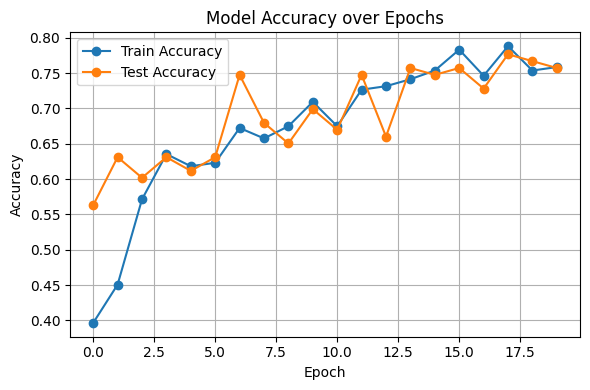

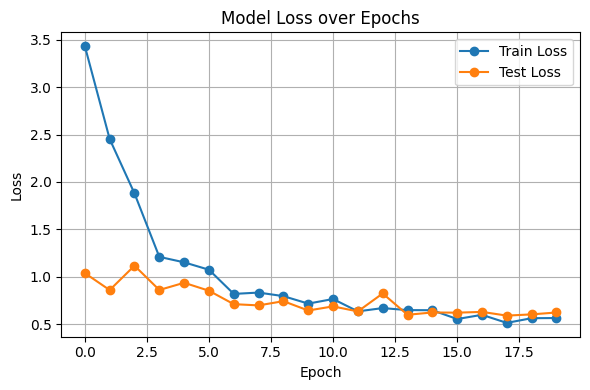

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# ---- Paths ----
train_dir = 'D:/Lung_cancer/train'
val_dir = 'D:/Lung_cancer/LC25000_sampled'
test_dir = 'D:/Lung_cancer/test'

# ---- Hyperparameters ----
batch_size = 16
dropout_rate = 0.5
learning_rate = 0.0005
target_size = (224, 224)
num_classes = 3 

# ---- Data Preprocessing ----
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed   
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

def build_model(base_model):
    base_model.trainable = False  # Freeze base layers
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs=base_model.input, outputs=output)

# ---- VGG19 Model ----
VGG16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = build_model(VGG16_base)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

print("\nTraining VGG16 Model...")
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    verbose=1
)

# ---- Evaluate VGG19 ----
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Evaluate for training
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the final model
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Final Validation Loss: {val_loss:.4f}")

import numpy as np
import pickle
# ---- Save the training history as a pickle file (.pkl) ----
history_file = 'vgg16_cv(new).pkl'

with open(history_file, 'wb') as f:
    pickle.dump(history.history, f)

print("Model training complete and history")

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot Loss ----
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Test Loss', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
🔍 Validation Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.82      0.69      0.75       500
               Nor       0.88      1.00      0.93       500
Squamous_carcinoma       0.81      0.82      0.81       500

          accuracy                           0.84      1500
         macro avg       0.83      0.84      0.83      1500
      weighted avg       0.83      0.84      0.83      1500

🔍 Test Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.74      0.72      0.73        39
               Nor       0.79      0.71      0.75        31
Squamous_carcinoma       0.76      0.85      0.80        33

          accuracy                           0.76       103
         macro avg       0.76      0.76      0.76       103
      weighted avg       0.76      0.76      0.76       103

Validation Accuracy: 0.836666

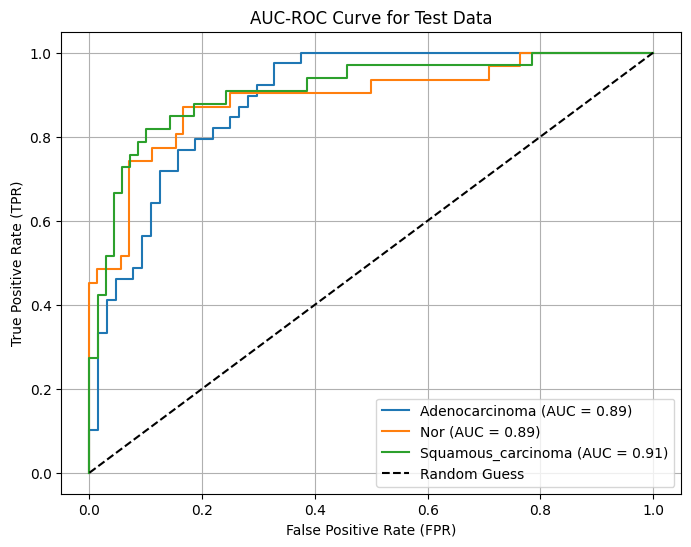


Macro-Averaged Test AUC: 0.90
94/94 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step

AUC-ROC for each class:
Adenocarcinoma - AUC: 0.93
Nor - AUC: 1.00
Squamous_carcinoma - AUC: 0.95


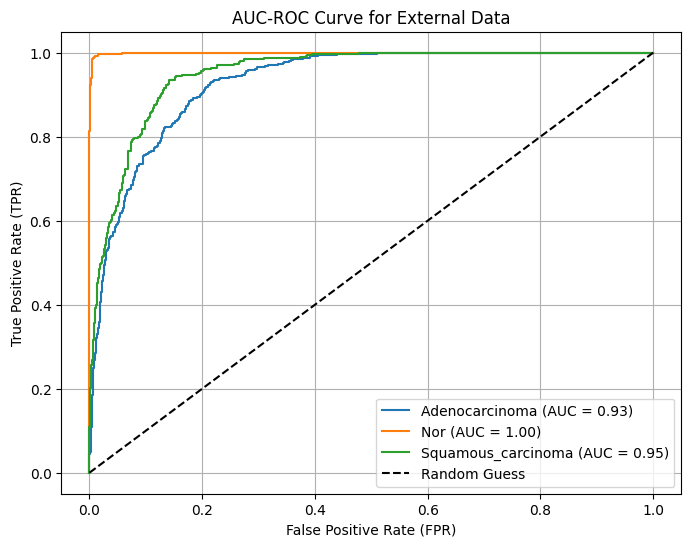


Macro-Averaged External AUC: 0.96


In [3]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
# Predicting on validation data
val_predictions = model.predict(val_generator)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = val_generator.classes

# Predicting on test data
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes
print("🔍 Validation Data Metrics:")
print(classification_report(val_true_labels, val_pred_labels, target_names=val_generator.class_indices.keys()))

print("🔍 Test Data Metrics:")
print(classification_report(test_true_labels, test_pred_labels, target_names=test_generator.class_indices.keys()))

# Additional individual metrics for better control
print("Validation Accuracy:", accuracy_score(val_true_labels, val_pred_labels))
print("Validation Precision:", precision_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation Recall:", recall_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation F1-Score:", f1_score(val_true_labels, val_pred_labels, average='weighted'))

print("Test Accuracy:", accuracy_score(test_true_labels, test_pred_labels))
print("Test Precision:", precision_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test Recall:", recall_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test F1-Score:", f1_score(test_true_labels, test_pred_labels, average='weighted'))

# Predict probabilities for the test dataset
test_predictions =model.predict(test_generator, verbose=1)

# True labels from the test generator
test_true_labels = test_generator.classes  # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
test_true_labels_binarized = label_binarize(test_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for Test Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(test_true_labels_binarized, test_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")

# Predict probabilities for the test dataset
val_predictions =model.predict(val_generator, verbose=1)

# True labels from the test generator
val_true_labels = val_generator.classes  # True class labels
class_labels = list(val_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
val_true_labels_binarized = label_binarize(val_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for External Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(val_true_labels_binarized, val_predictions, average="macro")
print(f"\nMacro-Averaged External AUC: {macro_roc_auc:.2f}")